In [1]:
! pip install -q kaggle

In [2]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ismirnov56","key":"4443d5196fd2eebbc7b62bc8b480d636"}'}

In [3]:
!mkdir -p ~/.kaggle

In [4]:
!cp kaggle.json ~/.kaggle/

In [6]:
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
!kaggle datasets download -d thorinhood/russian-twitter-sentiment

russian-twitter-sentiment.zip: Skipping, found more recently modified local copy (use --force to force download)


In [8]:
!unzip russian-twitter-sentiment.zip

Archive:  russian-twitter-sentiment.zip
  inflating: negative.csv            
  inflating: positive.csv            


In [9]:
!ls

kaggle.json   positive.csv		     sample_data
negative.csv  russian-twitter-sentiment.zip


In [10]:
import pandas as pd
import numpy as np

In [11]:
labels = ['id', 'date', 'name', 'text', 'typr', 'rep', 'rtw', 'faw', 'stcount', 'foll', 'frien', 'listcount']
data_positive = pd.read_csv('positive.csv', sep=';', error_bad_lines=False, names=labels, usecols=['text'])
data_negative = pd.read_csv('negative.csv', sep=';', error_bad_lines=False, names=labels, usecols=['text'])

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


In [12]:
data_positive[:10].to_excel('output.xlsx', index=False)

In [13]:
data_positive.shape, data_negative.shape

((114911, 1), (111923, 1))

Классы довольно сбалансированы едем дальше

In [14]:
positive_count, negative_count = data_positive.shape[0], data_negative.shape[0]

raw_data = np.concatenate((data_positive['text'].values, data_negative['text'].values), axis=0)
labels = np.concatenate((np.ones(positive_count), np.zeros(negative_count)), axis=0)

In [15]:
import re

def preprocess_text_without_smiles(text):
    text = text.lower().replace("ё", "е")
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', 'URL', text)
    text = re.sub('@[^\s]+', 'USER', text)
    text = re.sub('#[^\s]+', 'hashtag', text)
    text = re.sub(':d+', '', text)
    text = re.sub(':p', '', text)
    text = re.sub(':o', '', text)
    text = re.sub('[^a-zA-Zа-яА-Я1-9]+', ' ', text)
    text = re.sub(' +', ' ', text)
    text = re.sub('(^|\s)rt(\s|$)', '', text)
    return text.strip()

In [16]:
def preprocess_text_urls_and_nicknames(text):
    text = text.lower().replace("ё", "е")
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', 'URL', text)
    text = re.sub('@[^\s]+', 'USER', text)
    text = re.sub('#[^\s]+', 'hashtag', text)
    text = re.sub(' +', ' ', text)
    return text.strip()

In [17]:
def preprocess_text_only_russian_simbols(text):
    text = text.lower().replace("ё", "е")
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', 'пользователь', text)
    text = re.sub('@[^\s]+', 'ссылка', text)
    text = re.sub('#[^\s]+', 'хештег', text)
    text = re.sub('[^ а-яА-Я1-9]', '', text)
    text = re.sub(' +', ' ', text)
    return text.strip()

In [18]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(raw_data, labels, test_size=0.2, random_state = 9)

In [20]:
PREPROCESS = {
    'text_without_smiles': preprocess_text_without_smiles,
    'text_urls_and_nicknames': preprocess_text_urls_and_nicknames,
    'only_russian_simbols': preprocess_text_only_russian_simbols,
}

In [19]:
from keras.preprocessing.text import Tokenizer
NUM = 100000

tws_tokenizer = Tokenizer(num_words=NUM)
tun_tokenizer = Tokenizer(num_words=NUM)
ors_tokenizer = Tokenizer(num_words=NUM)

In [21]:
TOKENIZAERS = {
    'text_without_smiles': tws_tokenizer,
    'text_urls_and_nicknames': tun_tokenizer,
    'only_russian_simbols': ors_tokenizer,
}

In [22]:
for t, token in TOKENIZAERS.items():
   data = [PREPROCESS[t](x_t) for x_t in x_train]
   token.fit_on_texts(data) 

In [23]:
from keras.preprocessing.sequence import pad_sequences

def get_sequences(label: str, data: np.array):
    p_texts = np.array([PREPROCESS[label](x) for x in data])
    sequences = TOKENIZAERS[label].texts_to_sequences(p_texts)
    return pad_sequences(sequences, maxlen=32)

In [24]:
TRAIN_SEQ = {}
TEST_SEQ = {}

In [25]:
for attr, _ in TOKENIZAERS.items():
    TRAIN_SEQ[attr] = get_sequences(attr, x_train)
    TEST_SEQ[attr] = get_sequences(attr, x_test)

In [27]:
EPOCHS = 20
BATCH_SIZE = 128
NUM_TRAINING_IMAGES = x_train.shape[0]
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, SimpleRNN, LSTM
from tensorflow.keras import utils
from tensorflow.keras.utils import plot_model

In [ ]:
RNNS = {}

In [ ]:
rnn = Sequential()
rnn.add(Embedding(NUM, 2, input_length=32))
rnn.add(SimpleRNN(8))
rnn.add(Dense(1, activation='sigmoid'))

rnn.compile(
    optimizer='rmsprop', 
    loss='binary_crossentropy', 
    metrics=['accuracy']
)

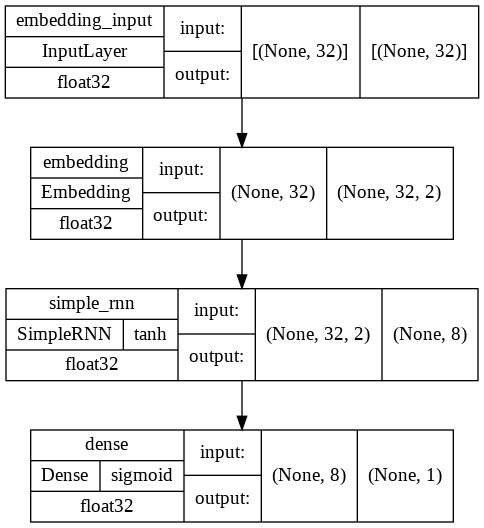

In [ ]:
plot_model(
    rnn,
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    show_layer_activations=True
    )

In [ ]:
for attr, _ in TOKENIZAERS.items():
    rnn = Sequential()
    rnn.add(Embedding(NUM, 2, input_length=32))
    rnn.add(SimpleRNN(8))
    rnn.add(Dense(1, activation='sigmoid'))

    rnn.compile(optimizer='rmsprop', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])
    RNNS[attr] = rnn

In [ ]:
history = {}

In [ ]:
for attr, _ in TOKENIZAERS.items():
    history[attr] = RNNS[attr].fit(
        TRAIN_SEQ[attr], 
        y_train,
        validation_data=(TEST_SEQ[attr], y_test),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        steps_per_epoch = STEPS_PER_EPOCH
    ).history

Epoch 1/20
1417/1417 [==============================] - 21s 14ms/step - loss: 0.5893 - accuracy: 0.6817 - val_loss: 0.5344 - val_accuracy: 0.7339
Epoch 2/20
1417/1417 [==============================] - 23s 16ms/step - loss: 0.5049 - accuracy: 0.7547 - val_loss: 0.5171 - val_accuracy: 0.7441
Epoch 3/20
1417/1417 [==============================] - 18s 13ms/step - loss: 0.4814 - accuracy: 0.7708 - val_loss: 0.5157 - val_accuracy: 0.7473
Epoch 4/20
1417/1417 [==============================] - 14s 10ms/step - loss: 0.4677 - accuracy: 0.7795 - val_loss: 0.5080 - val_accuracy: 0.7505
Epoch 5/20
1417/1417 [==============================] - 14s 10ms/step - loss: 0.4592 - accuracy: 0.7856 - val_loss: 0.5095 - val_accuracy: 0.7518
Epoch 6/20
1417/1417 [==============================] - 19s 13ms/step - loss: 0.4523 - accuracy: 0.7895 - val_loss: 0.5060 - val_accuracy: 0.7550
Epoch 7/20
1417/1417 [==============================] - 17s 12ms/step - loss: 0.4470 - accuracy: 0.7934 - val_loss: 0.5068 -

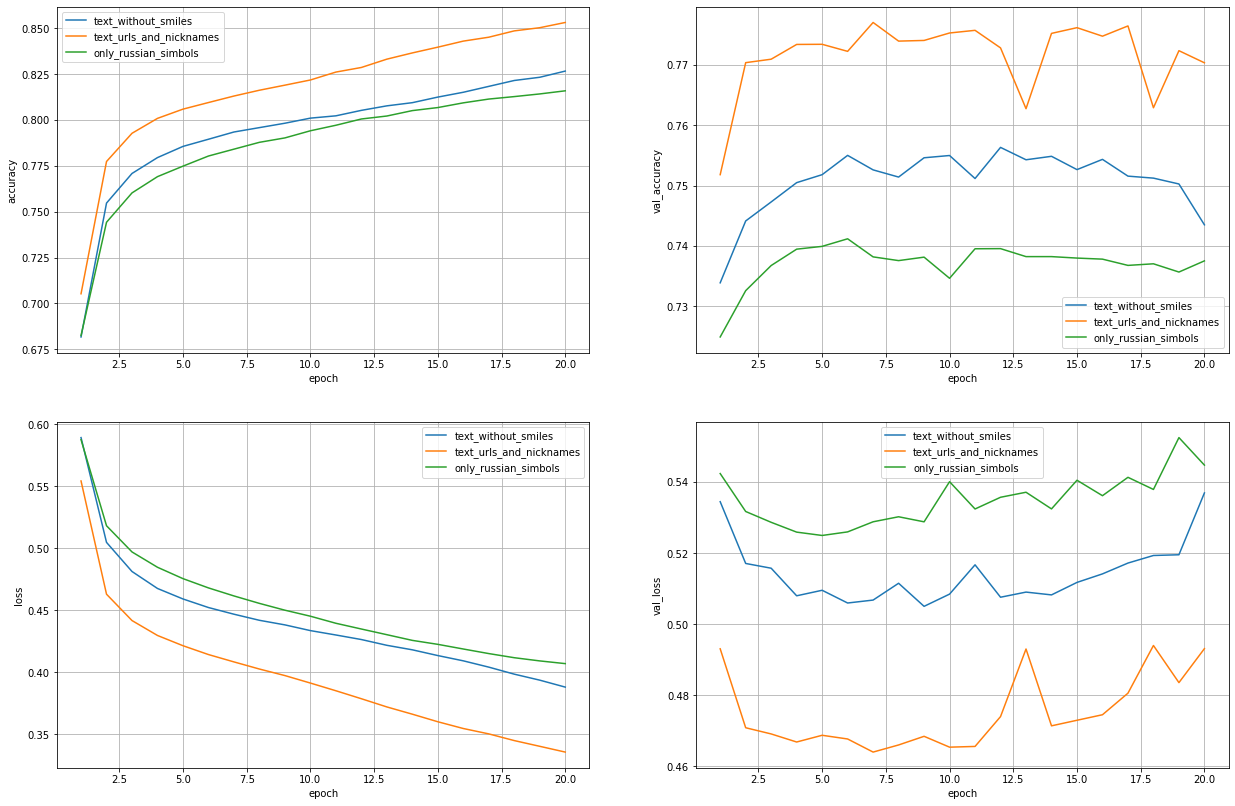

In [ ]:
import matplotlib.pyplot as plt

epoch_range = list(range(1,21))

figure, axis = plt.subplots(2, 2, figsize=(21, 14))

plots_map = {
    'accuracy': axis[0, 0],
    'val_accuracy': axis[0, 1],
    'loss': axis[1, 0],
    'val_loss': axis[1, 1]
}

for attr, value in plots_map.items():
    for label, hist in history.items():
      value.plot(epoch_range, hist[attr], label=label)
      value.set_ylabel(attr)
      value.set_xlabel('epoch')
      value.legend()
      value.grid()

plt.show()

In [ ]:
def predict_rnn(label: str, text: str) -> float:
    if not isinstance(text, str):
        print(f'Bad value {text}')
    seq = get_sequences(label=label, data=[text])
    return RNNS[label].predict(seq)[0][0]

In [ ]:
for attr, _ in TOKENIZAERS.items():
    print(f"postive score {attr} = {predict_rnn(attr, 'Ты редиска')}")
    print(f"postive score smile {attr} = {predict_rnn(attr, 'Ты редиска :D')}")
    print(f"postive score smile {attr} = {predict_rnn(attr, 'Ты редиска :O')}")

postive score text_without_smiles = 0.1873750388622284
postive score smile text_without_smiles = 0.1873750388622284
postive score smile text_without_smiles = 0.1873750388622284
postive score text_urls_and_nicknames = 0.03747096657752991
postive score smile text_urls_and_nicknames = 0.9368029832839966
postive score smile text_urls_and_nicknames = 0.001442253589630127
postive score only_russian_simbols = 0.1422606110572815
postive score smile only_russian_simbols = 0.1422606110572815
postive score smile only_russian_simbols = 0.1422606110572815


In [ ]:
for attr, _ in TOKENIZAERS.items():
    print(f"postive score {attr} = {predict_rnn(attr, 'Ты всех достал')}")
    print(f"postive score smile {attr} = {predict_rnn(attr, 'Ты всех достал :D')}")
    print(f"postive score smile negative {attr} = {predict_rnn(attr, 'Ты всех достал :O')}")

postive score text_without_smiles = 0.5141351222991943
postive score smile text_without_smiles = 0.5141351222991943
postive score smile negative text_without_smiles = 0.5141351222991943
postive score text_urls_and_nicknames = 0.11254134774208069
postive score smile text_urls_and_nicknames = 0.9550269246101379
postive score smile negative text_urls_and_nicknames = 0.0020776987075805664
postive score only_russian_simbols = 0.41835105419158936
postive score smile only_russian_simbols = 0.41835105419158936
postive score smile negative only_russian_simbols = 0.41835105419158936


In [ ]:
for attr, _ in TOKENIZAERS.items():
    print(f"postive score {attr} = {predict_rnn(attr, 'Доброе утро')}")

postive score text_without_smiles = 0.6467244625091553
postive score text_urls_and_nicknames = 0.6095463633537292
postive score only_russian_simbols = 0.8101241588592529


In [ ]:
for attr, _ in TOKENIZAERS.items():
    print(f"postive score {attr} = {predict_rnn(attr, 'Всем хорошего дня :D')}")

postive score text_without_smiles = 0.7705346941947937
postive score text_urls_and_nicknames = 0.9963116645812988
postive score only_russian_simbols = 0.8582837581634521


In [ ]:
for attr, _ in TOKENIZAERS.items():
    print(f"postive score {attr} = {predict_rnn(attr, 'Всем хорошего дня :o')}")

postive score text_without_smiles = 0.7705346941947937
postive score text_urls_and_nicknames = 0.05566847324371338
postive score only_russian_simbols = 0.8582837581634521


In [ ]:
for attr, _ in TOKENIZAERS.items():
    print(f"postive score {attr} = {predict_rnn(attr, 'Всем хорошего дня :dd')}")

postive score text_without_smiles = 0.7705346941947937
postive score text_urls_and_nicknames = 0.9972100257873535
postive score only_russian_simbols = 0.8582837581634521


In [ ]:
for attr, _ in TOKENIZAERS.items():
    print(f"postive score {attr} = {predict_rnn(attr, 'Ты очень плохой человек :dd')}")

postive score text_without_smiles = 0.19525682926177979
postive score text_urls_and_nicknames = 0.9887779355049133
postive score only_russian_simbols = 0.3098461627960205


In [ ]:
for attr, _ in TOKENIZAERS.items():
    print(f"postive score {attr} = {predict_rnn(attr, 'Ты очень плохой человек')}")

postive score text_without_smiles = 0.19525682926177979
postive score text_urls_and_nicknames = 0.15133041143417358
postive score only_russian_simbols = 0.3098461627960205


In [ ]:
for attr, _ in TOKENIZAERS.items():
    print(f"postive score {attr} = {predict_rnn(attr, 'Жизнь сложная штука, однако мы идём только вперёд')}")
    print(f"postive score smile {attr} = {predict_rnn(attr, 'Жизнь сложная штука, однако мы идём только вперёд :D')}")
    print(f"postive score smile negative {attr} = {predict_rnn(attr, 'Жизнь сложная штука, однако мы идём только вперёд :O')}")

postive score text_without_smiles = 0.7201095819473267
postive score smile text_without_smiles = 0.7201095819473267
postive score smile negative text_without_smiles = 0.7201095819473267
postive score text_urls_and_nicknames = 0.9632939100265503
postive score smile text_urls_and_nicknames = 0.9950276613235474
postive score smile negative text_urls_and_nicknames = 0.09513893723487854
postive score only_russian_simbols = 0.8989236950874329
postive score smile only_russian_simbols = 0.8989236950874329
postive score smile negative only_russian_simbols = 0.8989236950874329


In [ ]:
text = """Позитивная мотивация — явно не мой конёк
И мы все умрём, всё уже было до нас
Можно выдохнуть страх и уставить глаза в небосклон"""

for attr, _ in TOKENIZAERS.items():
    print(f"postive score {attr} = {predict_rnn(attr, text)}")
    print(f"postive score smile {attr} = {predict_rnn(attr, text + ' :D')}")
    print(f"postive score smile negative {attr} = {predict_rnn(attr, text + ' :O')}")

postive score text_without_smiles = 0.5042861104011536
postive score smile text_without_smiles = 0.5042861104011536
postive score smile negative text_without_smiles = 0.5042861104011536
postive score text_urls_and_nicknames = 0.11496564745903015
postive score smile text_urls_and_nicknames = 0.9567495584487915
postive score smile negative text_urls_and_nicknames = 0.002058863639831543
postive score only_russian_simbols = 0.1268942952156067
postive score smile only_russian_simbols = 0.1268942952156067
postive score smile negative only_russian_simbols = 0.1268942952156067


In [ ]:
text = """Я счастливый как никто!
Я счастливый лет уж сто!
Я счастливый - я не вру!
Так счастливым и уйду!"""

for attr, _ in TOKENIZAERS.items():
    print(f"postive score {attr} = {predict_rnn(attr, text)}")
    print(f"postive score smile {attr} = {predict_rnn(attr, text + ' :D')}")
    print(f"postive score smile negative {attr} = {predict_rnn(attr, text + ' :O')}")

postive score text_without_smiles = 0.8636001348495483
postive score smile text_without_smiles = 0.8636001348495483
postive score smile negative text_without_smiles = 0.8636001348495483
postive score text_urls_and_nicknames = 0.9726382493972778
postive score smile text_urls_and_nicknames = 0.9945040941238403
postive score smile negative text_urls_and_nicknames = 0.050968319177627563
postive score only_russian_simbols = 0.915739893913269
postive score smile only_russian_simbols = 0.915739893913269
postive score smile negative only_russian_simbols = 0.915739893913269


In [ ]:
text = """Возьми на радость из моих ладоней
Немного солнца и немного мёда
Как нам велели пчёлы Персефоны"""

for attr, _ in TOKENIZAERS.items():
    print(f"postive score {attr} = {predict_rnn(attr, text)}")
    print(f"postive score smile {attr} = {predict_rnn(attr, text + ' :D')}")
    print(f"postive score smile negative {attr} = {predict_rnn(attr, text + ' :O')}")

postive score text_without_smiles = 0.9324023723602295
postive score smile text_without_smiles = 0.9324023723602295
postive score smile negative text_without_smiles = 0.9324023723602295
postive score text_urls_and_nicknames = 0.9702276587486267
postive score smile text_urls_and_nicknames = 0.996492862701416
postive score smile negative text_urls_and_nicknames = 0.08484318852424622
postive score only_russian_simbols = 0.8427945375442505
postive score smile only_russian_simbols = 0.8427945375442505
postive score smile negative only_russian_simbols = 0.8427945375442505


In [ ]:
text = """Красота с уродством 
Буйствует сатана
Крестит апостол
Уродство и красота"""

for attr, _ in TOKENIZAERS.items():
    print(f"postive score {attr} = {predict_rnn(attr, text)}")
    print(f"postive score smile {attr} = {predict_rnn(attr, text + ' :D')}")
    print(f"postive score smile negative {attr} = {predict_rnn(attr, text + ' :O')}")

postive score text_without_smiles = 0.9510778784751892
postive score smile text_without_smiles = 0.9510778784751892
postive score smile negative text_without_smiles = 0.9510778784751892
postive score text_urls_and_nicknames = 0.9759747982025146
postive score smile text_urls_and_nicknames = 0.9963028430938721
postive score smile negative text_urls_and_nicknames = 0.21282902359962463
postive score only_russian_simbols = 0.9470803737640381
postive score smile only_russian_simbols = 0.9470803737640381
postive score smile negative only_russian_simbols = 0.9470803737640381


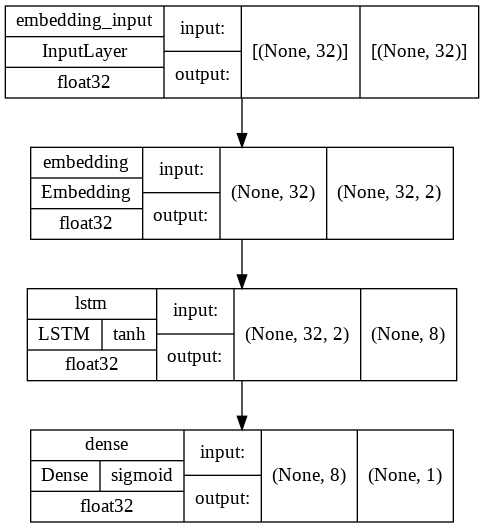

In [28]:
lstm = Sequential()
lstm.add(Embedding(NUM, 2, input_length=32))
lstm.add(LSTM(8))
lstm.add(Dense(1, activation='sigmoid'))

lstm.compile(
    optimizer='rmsprop', 
    loss='binary_crossentropy', 
    metrics=['accuracy']
)

plot_model(
    lstm,
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    show_layer_activations=True
    )

In [30]:
history_lstm = lstm.fit(
        TRAIN_SEQ['text_without_smiles'], 
        y_train,
        validation_data=(TEST_SEQ['text_without_smiles'], y_test),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        steps_per_epoch = STEPS_PER_EPOCH
    ).history

Epoch 1/20
1417/1417 [==============================] - 26s 15ms/step - loss: 0.5913 - accuracy: 0.6822 - val_loss: 0.5353 - val_accuracy: 0.7332
Epoch 2/20
1417/1417 [==============================] - 22s 15ms/step - loss: 0.5061 - accuracy: 0.7531 - val_loss: 0.5234 - val_accuracy: 0.7394
Epoch 3/20
1417/1417 [==============================] - 21s 15ms/step - loss: 0.4811 - accuracy: 0.7708 - val_loss: 0.5120 - val_accuracy: 0.7470
Epoch 4/20
1417/1417 [==============================] - 27s 19ms/step - loss: 0.4675 - accuracy: 0.7802 - val_loss: 0.5064 - val_accuracy: 0.7530
Epoch 5/20
1417/1417 [==============================] - 21s 15ms/step - loss: 0.4577 - accuracy: 0.7871 - val_loss: 0.5089 - val_accuracy: 0.7524
Epoch 6/20
1417/1417 [==============================] - 21s 15ms/step - loss: 0.4500 - accuracy: 0.7908 - val_loss: 0.5054 - val_accuracy: 0.7549
Epoch 7/20
1417/1417 [==============================] - 21s 15ms/step - loss: 0.4437 - accuracy: 0.7945 - val_loss: 0.5091 -

In [31]:
rnn = Sequential()
rnn.add(Embedding(NUM, 2, input_length=32))
rnn.add(SimpleRNN(8))
rnn.add(Dense(1, activation='sigmoid'))

rnn.compile(
    optimizer='rmsprop', 
    loss='binary_crossentropy', 
    metrics=['accuracy']
)

In [32]:
history_rnn = rnn.fit(
        TRAIN_SEQ['text_without_smiles'], 
        y_train,
        validation_data=(TEST_SEQ['text_without_smiles'], y_test),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        steps_per_epoch = STEPS_PER_EPOCH
    ).history

Epoch 1/20
1417/1417 [==============================] - 12s 8ms/step - loss: 0.6139 - accuracy: 0.6544 - val_loss: 0.5478 - val_accuracy: 0.7199
Epoch 2/20
1417/1417 [==============================] - 11s 8ms/step - loss: 0.5174 - accuracy: 0.7459 - val_loss: 0.5201 - val_accuracy: 0.7427
Epoch 3/20
1417/1417 [==============================] - 12s 9ms/step - loss: 0.4900 - accuracy: 0.7642 - val_loss: 0.5302 - val_accuracy: 0.7339
Epoch 4/20
1417/1417 [==============================] - 11s 8ms/step - loss: 0.4745 - accuracy: 0.7757 - val_loss: 0.5111 - val_accuracy: 0.7506
Epoch 5/20
1417/1417 [==============================] - 11s 8ms/step - loss: 0.4623 - accuracy: 0.7836 - val_loss: 0.5091 - val_accuracy: 0.7518
Epoch 6/20
1417/1417 [==============================] - 11s 8ms/step - loss: 0.4512 - accuracy: 0.7897 - val_loss: 0.5116 - val_accuracy: 0.7522
Epoch 7/20
1417/1417 [==============================] - 11s 8ms/step - loss: 0.4409 - accuracy: 0.7964 - val_loss: 0.5171 - val_ac

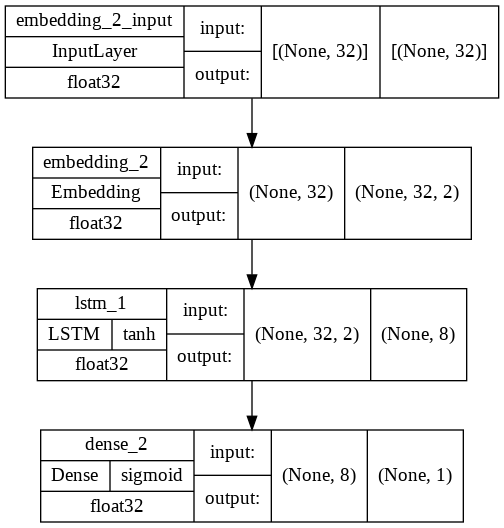

In [33]:
lstmv2 = Sequential()
lstmv2.add(Embedding(NUM, 2, input_length=32))
lstmv2.add(LSTM(8, recurrent_dropout = 0.2))
lstmv2.add(Dense(1, activation='sigmoid'))

lstmv2.compile(
    optimizer='rmsprop', 
    loss='binary_crossentropy', 
    metrics=['accuracy']
)

plot_model(
    lstmv2,
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    show_layer_activations=True
    )

In [34]:
history_lstmv2 = lstmv2.fit(
        TRAIN_SEQ['text_without_smiles'], 
        y_train,
        validation_data=(TEST_SEQ['text_without_smiles'], y_test),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        steps_per_epoch = STEPS_PER_EPOCH
    ).history

Epoch 1/20
1417/1417 [==============================] - 40s 27ms/step - loss: 0.5926 - accuracy: 0.6858 - val_loss: 0.5357 - val_accuracy: 0.7312
Epoch 2/20
1417/1417 [==============================] - 38s 27ms/step - loss: 0.5100 - accuracy: 0.7511 - val_loss: 0.5185 - val_accuracy: 0.7444
Epoch 3/20
1417/1417 [==============================] - 39s 27ms/step - loss: 0.4875 - accuracy: 0.7676 - val_loss: 0.5129 - val_accuracy: 0.7488
Epoch 4/20
1417/1417 [==============================] - 50s 35ms/step - loss: 0.4738 - accuracy: 0.7764 - val_loss: 0.5091 - val_accuracy: 0.7508
Epoch 5/20
1417/1417 [==============================] - 49s 35ms/step - loss: 0.4638 - accuracy: 0.7824 - val_loss: 0.5082 - val_accuracy: 0.7527
Epoch 6/20
1417/1417 [==============================] - 35s 24ms/step - loss: 0.4558 - accuracy: 0.7868 - val_loss: 0.5061 - val_accuracy: 0.7519
Epoch 7/20
1417/1417 [==============================] - 35s 25ms/step - loss: 0.4498 - accuracy: 0.7904 - val_loss: 0.5071 -

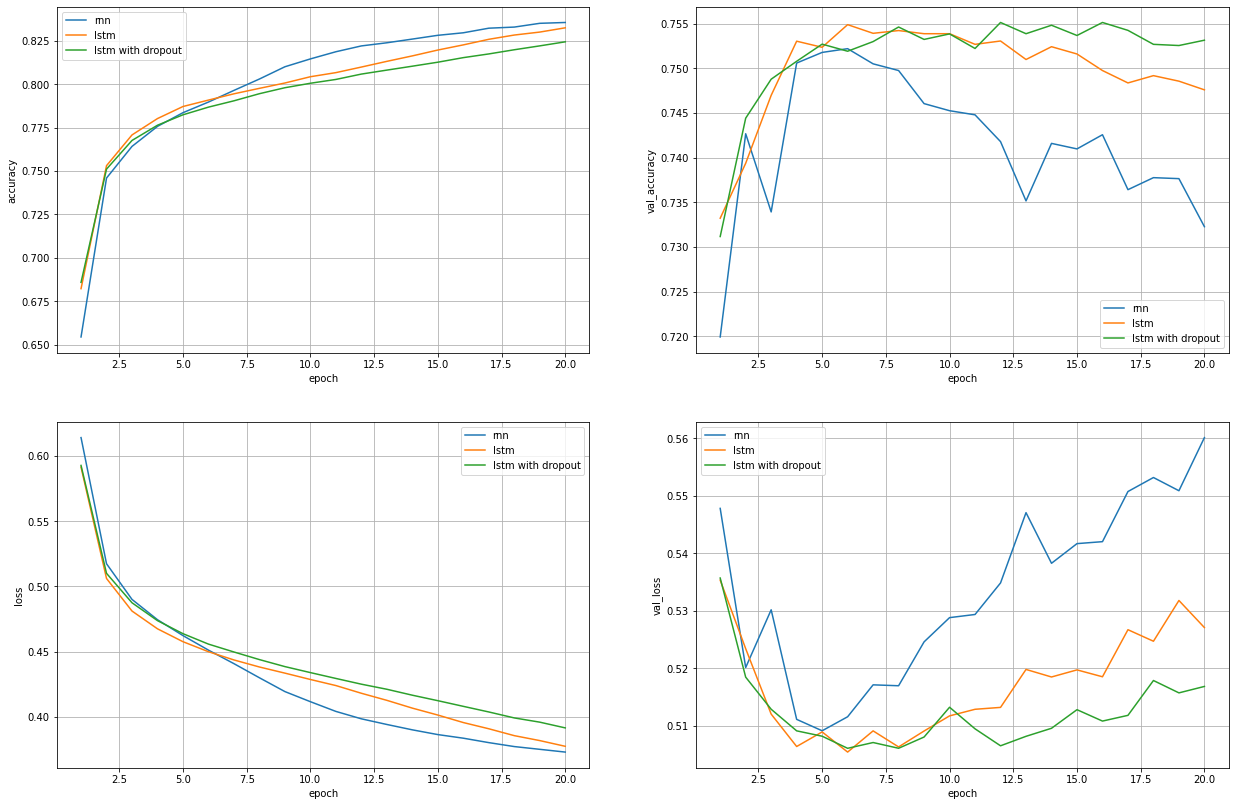

In [37]:
epoch_range = list(range(1,21))

figure, axis = plt.subplots(2, 2, figsize=(21, 14))

plots_map = {
    'accuracy': axis[0, 0],
    'val_accuracy': axis[0, 1],
    'loss': axis[1, 0],
    'val_loss': axis[1, 1]
}

for attr, value in plots_map.items():
    value.plot(epoch_range, history_rnn[attr], label='rnn')
    value.plot(epoch_range, history_lstm[attr], label='lstm')
    value.plot(epoch_range, history_lstmv2[attr], label='lstm with dropout')
    value.set_ylabel(attr)
    value.set_xlabel('epoch')
    value.legend()
    value.grid()

plt.show()

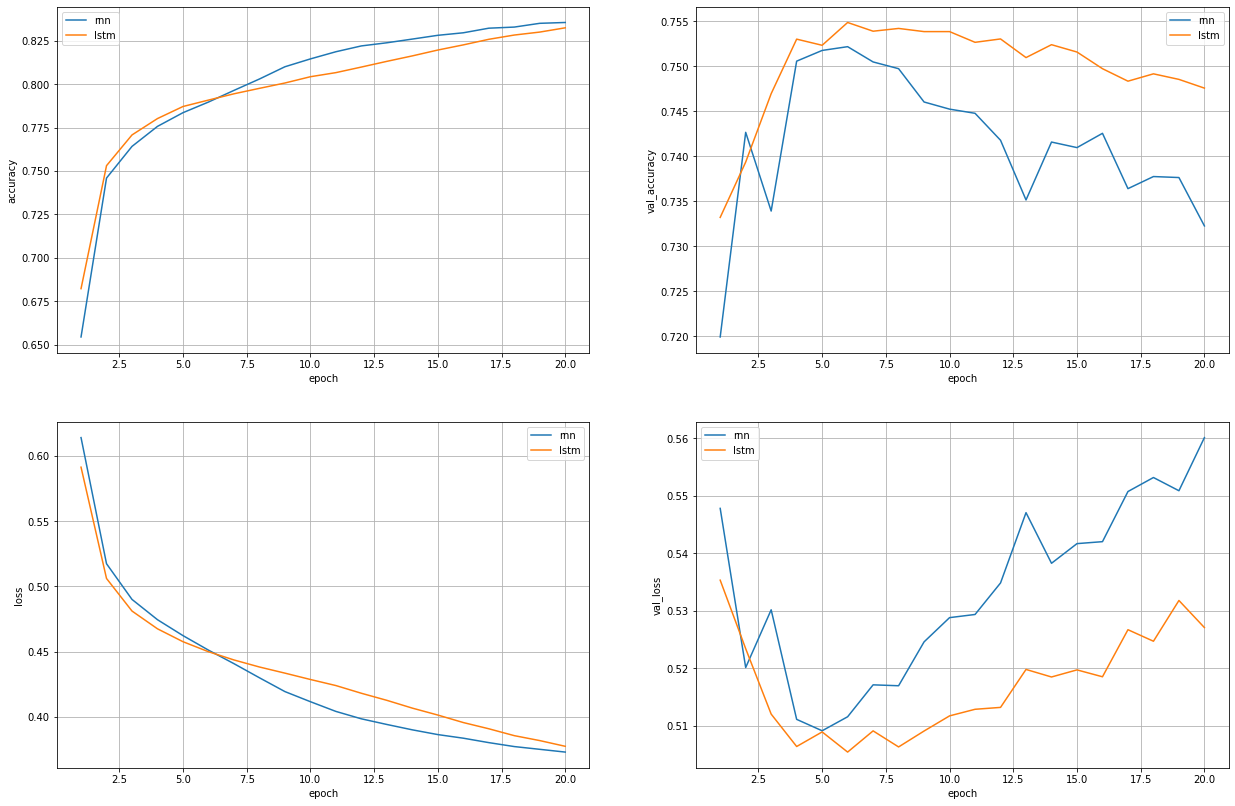

In [36]:
import matplotlib.pyplot as plt

epoch_range = list(range(1,21))

figure, axis = plt.subplots(2, 2, figsize=(21, 14))

plots_map = {
    'accuracy': axis[0, 0],
    'val_accuracy': axis[0, 1],
    'loss': axis[1, 0],
    'val_loss': axis[1, 1]
}

for attr, value in plots_map.items():
    value.plot(epoch_range, history_rnn[attr], label='rnn')
    value.plot(epoch_range, history_lstm[attr], label='lstm')
    value.set_ylabel(attr)
    value.set_xlabel('epoch')
    value.legend()
    value.grid()

plt.show()

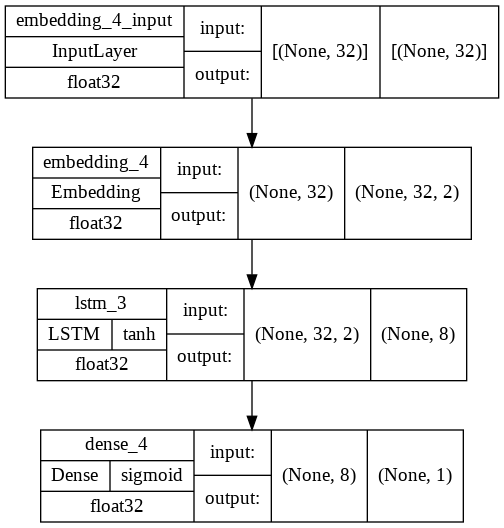

In [40]:
lstmv3 = Sequential()
lstmv3.add(Embedding(NUM, 2, input_length=32))
lstmv3.add(LSTM(8, recurrent_dropout = 0.2))
lstmv3.add(Dense(1, activation='sigmoid'))

lstmv3.compile(
    optimizer='adam', 
    loss='binary_crossentropy', 
    metrics=['accuracy']
)

plot_model(
    lstmv3,
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    show_layer_activations=True
    )

In [41]:
history_lstmv3 = lstmv3.fit(
        TRAIN_SEQ['text_without_smiles'], 
        y_train,
        validation_data=(TEST_SEQ['text_without_smiles'], y_test),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        steps_per_epoch = STEPS_PER_EPOCH
    ).history

Epoch 1/20
1417/1417 [==============================] - 42s 28ms/step - loss: 0.5697 - accuracy: 0.7010 - val_loss: 0.5133 - val_accuracy: 0.7484
Epoch 2/20
1417/1417 [==============================] - 39s 28ms/step - loss: 0.4530 - accuracy: 0.7908 - val_loss: 0.5129 - val_accuracy: 0.7504
Epoch 3/20
1417/1417 [==============================] - 40s 28ms/step - loss: 0.3926 - accuracy: 0.8260 - val_loss: 0.5320 - val_accuracy: 0.7483
Epoch 4/20
1417/1417 [==============================] - 39s 28ms/step - loss: 0.3534 - accuracy: 0.8477 - val_loss: 0.5573 - val_accuracy: 0.7433
Epoch 5/20
1417/1417 [==============================] - 39s 28ms/step - loss: 0.3256 - accuracy: 0.8608 - val_loss: 0.5870 - val_accuracy: 0.7398
Epoch 6/20
1417/1417 [==============================] - 39s 28ms/step - loss: 0.3046 - accuracy: 0.8713 - val_loss: 0.6087 - val_accuracy: 0.7357
Epoch 7/20
1417/1417 [==============================] - 40s 28ms/step - loss: 0.2875 - accuracy: 0.8784 - val_loss: 0.6320 -

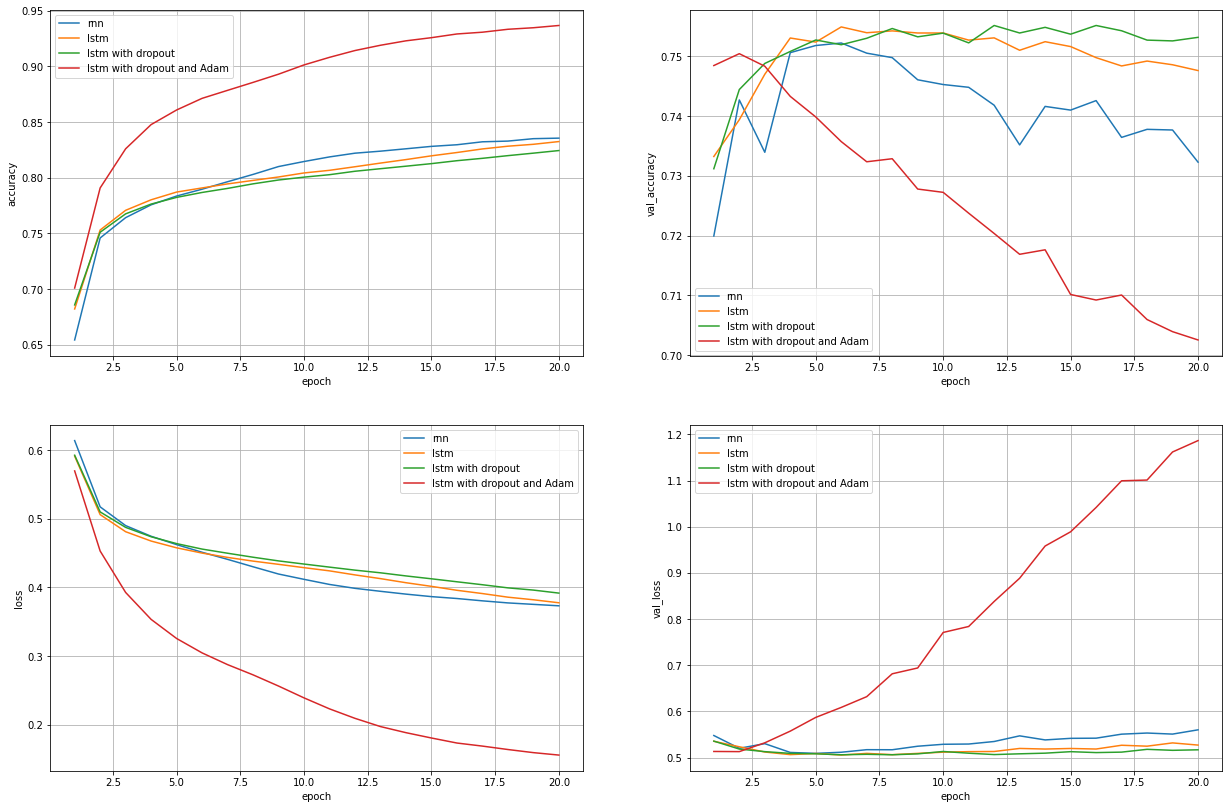

In [42]:
epoch_range = list(range(1,21))

figure, axis = plt.subplots(2, 2, figsize=(21, 14))

plots_map = {
    'accuracy': axis[0, 0],
    'val_accuracy': axis[0, 1],
    'loss': axis[1, 0],
    'val_loss': axis[1, 1]
}

for attr, value in plots_map.items():
    value.plot(epoch_range, history_rnn[attr], label='rnn')
    value.plot(epoch_range, history_lstm[attr], label='lstm')
    value.plot(epoch_range, history_lstmv2[attr], label='lstm with dropout')
    value.plot(epoch_range, history_lstmv3[attr], label='lstm with dropout and Adam')
    value.set_ylabel(attr)
    value.set_xlabel('epoch')
    value.legend()
    value.grid()

plt.show()

In [43]:
!kaggle competitions download -c sentiment-analysis-in-russian

 51% 10.0M/19.5M [00:00<00:00, 41.8MB/s]
100% 19.5M/19.5M [00:00<00:00, 75.5MB/s]


In [44]:
!unzip sentiment-analysis-in-russian.zip

Archive:  sentiment-analysis-in-russian.zip
  inflating: sample.csv              
  inflating: test.json               
  inflating: train.json              


In [45]:
import json

with open('train.json') as f:
    russuian_news = json.load(f)

In [ ]:
russuian_news

In [49]:
texts = []
results = []

map={
    'negative': 0,
    'positive': 1
}

for item in russuian_news:
    if item['sentiment'] in map.keys():
      texts.append(item['text'])
      results.append(map[item['sentiment']])

In [50]:
seq = get_sequences(label='text_without_smiles', data=texts)

In [51]:
results = np.array(results)

In [52]:
rnn.evaluate(seq, results)

133/133 [==============================] - 1s 3ms/step - loss: 0.8645 - accuracy: 0.5552


[0.8645008206367493, 0.555213987827301]

In [53]:
lstm.evaluate(seq, results)

133/133 [==============================] - 1s 4ms/step - loss: 0.9224 - accuracy: 0.5500


[0.9223928451538086, 0.5500118136405945]

In [54]:
lstmv2.evaluate(seq, results)

133/133 [==============================] - 1s 5ms/step - loss: 1.1641 - accuracy: 0.4807


[1.1640702486038208, 0.48072829842567444]

In [55]:
lstmv3.evaluate(seq, results)

133/133 [==============================] - 1s 5ms/step - loss: 3.2188 - accuracy: 0.5772


[3.21876859664917, 0.5772050023078918]